In [1]:
import re
from os import path

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    RandomizedSearchCV,
)
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
48959,1559770894045794312,tem duas jurupinga e um corote na minha gelade...,-0.093377,-1
886,1559737934869254145,ñ 💔 💔 m m .p lñ,-0.243902,-1
376245,1559993471200595974,queria participar de um grupo de collector p n...,-0.080586,-1
269523,1559925669076910082,meu neném loirinho ta a coisa mais linda desse...,0.669873,1
98952,1559848804278587393,verdade 😂😂😂,0.662905,1
751610,1161034489340014593,isso aqui causou um bafo na tl que vou te cont...,0.220968,0
759253,1161051351314587650,minha net dados tá foda n ta dando pra ver stts 😑,-0.314381,-1
865992,1161306391874822144,acabei de falar com a minha mãe! 😍,0.677937,1
715094,1160975228916379651,só por que eu vim embora tu aparece né 😔,-0.146058,-1
742175,1161018286710185984,"a vida é igual restaurante, você nunca sai sem...",0.449977,1


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [
            substring
            for substring in string_tratada.split()
            if substring not in stopwords
        ]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join(
            [stemmer.stem(substring) for substring in string_tratada.split()]
        )

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

46      estavam
89       houver
151         ser
52        estes
187    tínhamos
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: você é vibe killer man 😏

Tweet Limpo   : vibe killer man

Tweet Stemed  : vib kill man


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
545667,1160715401296273408,também quero que você volte ! ❤,0.746087,1,quer volt
209553,1559901952057769986,vídeo completo no meu privacy 😏😈,0.600150,1,víde complet privacy
653803,1160892774754988032,q ódio disso 😠,-0.302083,-1,q ódi diss
850000,1161268631445131264,chega em casa e dar uma geral pra sair com a s...,0.332457,1,cheg cas dar geral pra sair sam
308514,1559960666903027713,mas que barbaridade!!! os juízes se levantam c...,0.190265,0,barbar juíz levant contr pag coleg comet arbit...


# Engenharia de Atributos: TF-IDF Vectorizer

Este modelo utiliza uma matriz esparsa com a frequencia de cada palavra.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

### TF-IDF Vectorizer

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train["cleaned"])

TfidfVectorizer(ngram_range=(1, 2))

#### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [12]:
X_features_train = vectorizer.transform(X_train["cleaned"])
y_features_train = X_train["label"]

#### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [13]:
X_features_test = vectorizer.transform(X_test["cleaned"])
y_features_test = X_test["label"]

## Seleção de Atributos

Referência:

- [https://en.wikipedia.org/wiki/Feature_selection](https://en.wikipedia.org/wiki/Feature_selection)
- [https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

In [14]:
selector = SelectPercentile(f_classif, percentile=60)

selector.fit(X_features_train, y_features_train)

SelectPercentile(percentile=60)

In [15]:
X_features_train_selected = selector.transform(X_features_train)
X_features_test_selected = selector.transform(X_features_test)

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [16]:
# Inicializar o Scaler
scaler = StandardScaler(with_mean=False)

# Treinar o Scaler
scaler.fit(X_features_train_selected)

StandardScaler(with_mean=False)

In [17]:
# Transformar o conjunto de treinamento
X_features_train_scaled = scaler.transform(X_features_train_selected)

In [18]:
X_features_test_scaled = scaler.transform(X_features_test_selected)

# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [19]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 3.64%


In [20]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 11.62%


In [21]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 43.03%


In [22]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 43.03%


## Naive Bayes

Referências:
- [https://en.wikipedia.org/wiki/Naive_Bayes_classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)

In [23]:
nb = MultinomialNB()

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [24]:
params = {
    "alpha": np.sort(np.append(np.linspace(0.5, 1.5, 20), 1)),
}

clf = RandomizedSearchCV(
    nb, params, n_iter=10, scoring="f1_weighted", n_jobs=-1, random_state=42
)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 64.24%


In [25]:
clf.best_params_

{'alpha': 1.2894736842105263}

In [26]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [27]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_ * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - clf.best_score_) * 100))

Score Baseline : 43.03%
Score Modelo   : 64.24%
Diferença      : 21.22%


### Performance no Conjunto de Treino

In [28]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 88.71%


### Curva de Aprendizado

In [29]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

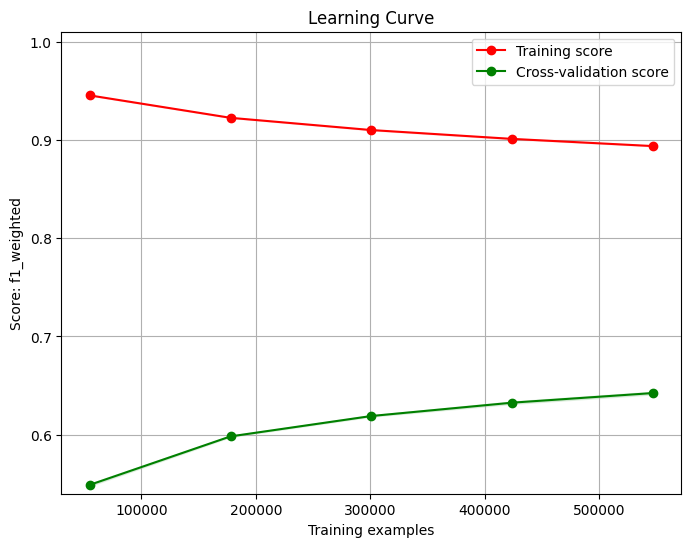

In [30]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Validação em conjunto de Teste

In [31]:
y_pred = classifier.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 59.93%


### Preditos Positivos

In [32]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [33]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['onde precisava de estar 😔', 'o grêmio é muito filho da puta 😞',
       'queria ir tanto cntg best 💔',
       'feliz dia dos pais para minha mãe 😭',
       'ate pq teu aniversário é só dia 😴', 'o lucas é fofinho demais 😭',
       'mas eu te amo 😭', 'vai pra pqp 😠', 'não fica assim princesa 😔',
       'henrique e juliano e ícaro e gilmar 😭'], dtype=object)

#### Falso Positivo -> Neutro

In [34]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['sexooo 😂',
       'acho que ainda tô no pique de ontem pq tô no trabalho meczada 😂 hj tá molezinha',
       'compra pra mim tsb dia do mes q vem te pago 😅',
       'novo visual da canhanduba 😂', 'tô nem aí 😅',
       'da aonde saiu isso kkk😂',
       'muito bom dia que hoje é dia de guerra 🔥⚫️🔴', 'ahahahshdb elədi😂',
       'sdds carnaval — sddsss quem é ? 👀',
       'vamos beber até a raiva passar! 😂'], dtype=object)

#### Verdadeiro Positivo

In [35]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['bom dia👋', 'minha base 💙', 'quase lá 😂😂😂',
       'nossa que bonito isso 👏', 'kkk queeemmm 😆',
       'gratidão a deus por tudo ❤️\u200d🔥', 'obg anjo 💖', 'hai eunha 👋',
       'eu tenho a melhor sogra do mundo, meu amor todinho 💕',
       'aqui se faz, aqui se paga 😊'], dtype=object)

### Preditos Negativos

In [36]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [37]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['calma shura, envaina esa excalibur... 😏',
       'é que o moleque mora longe mas mora onde o sorriso é mais feliz 🎶',
       'mimem meu fixado novo obrigada 💜',
       'eu consigo ser gostosa sem ser vulgar 😌',
       'esse livro tá na minha listaaa 💖', 'você que é ne amg 😍',
       'mary, já pode marcar com o tatuador! 🌸',
       'pitico do meu coração 💜 amo tanto,ele tem q entender que ele precisa bagabundear um pouco,ficar só na sombra e agu…',
       '😂😂😂 é o crl 🙄🙄🙄 aqui é 🚩🚩🚩',
       'e eu uma hora dessas tentando achar o facebook da melhor professora que eu tive no ensino médio. profa valéria 💖'],
      dtype=object)

#### Falso Negativo -> Neutro

In [38]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['é péssimo 😂', 'ney ney no barça da link como? 😂',
       'vocês sabem o que é passar na média em duas disciplinas que tu nem sequer abriu um livro pra estudar? muito deus na minha vida 😂',
       'sua filha parece sua irmã cara, é impressionante!😱',
       'só queria conseguir compra o ingresso p jogo de quarta 😢',
       'to c uma dor horrível 😥', 'tbm tô sentindo sua falta 😢',
       'pb ficou puto, colocou pra escolhe equipe 🎮😅',
       'a sarah que está fazendo as coisas e agora a culpa é minha 😂',
       'só um praiou no sábado 🥵😂'], dtype=object)

#### Verdadeiro Negativo

In [39]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['estou cansado de tanta humilhação 😪', 'eu qria 💔',
       'horas de salto alto, meus pés estão pedindo socorro 😪',
       'porra mn, velozes e furiosos sempre consegue fazer eu chorar, eu nunca vou superar a morte do paul 😭',
       'acostumei à dormir com a thalita e quando acordei fiquei procurando ela 😔',
       'meus pêsames, que deus conforte o coração de toda a família 😔🖤',
       'tudo ta me irritando até a sofia, o dias difícil 😤',
       'pq vai chover kkk 😭', 'dm é wpp tá morto 😴',
       'to esperando aqui poxa 😞'], dtype=object)

### Preditos Neutros

In [40]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [41]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['não vai sobrar ngm vivo 🔥🔥',
       'literalmente eu quando vi essas fotos do jungoo😂😂😂',
       'muitos pagam de responsa, mas poucos representam na atitude... 🍃',
       'bora segurar a onda e outras coisas mais... haha 😆',
       'se programem, de set é logo ali e eu quero presente ♥',
       'gabriel vai tatuar meu nome bem grande no peito dele q amor 😍',
       'o bom disso é que eu tenho informações dos dois lados 💗💗',
       '[ / / : : ] biela: ❤ [ / / : : ] biela: chal🖐🏽 depois de fazer a fofoca kkk',
       '😂😂😂 oh caraças',
       'o meu cunhado vai-me emprestar a ps dele porque ele não a utiliza muito. cuteee ❤'],
      dtype=object)

#### Falso Neutro -> Negativo

In [42]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['ridículo 😡😡',
       '😭😭😭 barcode não faça isso com seu phi eu vi o que você fez eu era a água',
       'queria continuar no sol, pena q tenho q trabalhar 😩',
       'a barbie sem aparecer pois nao teve falas nessa temporada 😭',
       'vc que esquece que tem namorada 😡',
       'ando tão cansada ultimamente, tem acontecido tanta coisa. foda 😞',
       'não bota culpa no menino não palhaço 😒 , bola de cristal quebrou, fala aí vai comprar oq mexmo ? 🤣🤣🤣',
       'deixam de responder bem à toa 😑', 'tô com vontade de chorar hj 😠',
       'reação dos meninos quando voltar pra casa sem nenhum prêmio 💔 ( deus faça com que eles ganhem)'],
      dtype=object)

#### Verdadeiro Neutro

In [43]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['ellie eh outro nivel neh kkk twitteiras sao mais honestas 😂',
       'kkk gente essas mona pensa que passa batida, nem p fazer fake elas prestam 😅',
       '👀 hahaha porra! aí não... pode cobrar isso dele sim.',
       'alguém pra tomar um café na di pappi 👀',
       'a crise está tão feia que ia pedir pra me buscar em casa pra nós ir pra faculdade 😅',
       'único dia da semana que minha autoestima está alta 😅',
       'aí lourenço lourenço 😂', 'ja deveria ter desistido faz tempo 😂',
       'e ainda dizem que nós, sagitarianos, não somos: uma grande mentira, pois tbm sou bastante 😂',
       'eita 🤭🔥'], dtype=object)